# HMM Training Tutorial

Welcome to the training tutorial! Since Homomorph doesn't have built-in methods for fitting HMMs to data, in this tutorial we'll cover examples of training HMMs where 1) the output distribution is discrete and continuous and 2) the hidden states are both known and unknown using maximum-likelihood criteria. Finally, we'll discuss a more advanced approach called discriminative training. We have a lot of ground to cover, so let's get started!

This is a long tutorial, so I've included a table of of contents below that links to each section.
- [1 What is training?](#1-What-is-training?)
 - [1.1 Training, informally](#1.1-Training,-informally)
 - [1.2 Training, formally](#1.2-Training,-formally)
- [2 Training with known states](#2-Training-with-known-states)
 - [2.1 Maximum-likelihood estimation](#2.1-Maximum-likelihood-estimation)
 - [2.2 Maximum likelihood estimates for HMMs](#2.2-Maximum-likelihood-estimates-for-HMMs)
 - [2.3 Examples](#2.3-Examples)
   - [2.3.1 Categorical emission distribution](#2.3.1-Categorical-emission-distribution)
   - [2.3.2 Discrete emission distribution](#2.3.2-Discrete-emission-distribution)
   - [2.3.3 Continuous emission distribution](#2.3.3-Continuous-emission-distribution)
- [3 Training with unknown states](#3-Training-with-unknown-states)
 - [3.1 Estimation-maximization, informally](#3.1-Estimation-maximization,-informally)
 - [3.2 Implementing Baum-Welch for categorical distributions](#3.2-Implementing-Baum-Welch-for-categorical-distributions)
 - [3.3 Estimation-maximization, formally](#3.3-Estimation-maximization,-formally)
 - [3.4 Deriving the update equations for a normal distribution](#3.4-Deriving-the-update-equations-for-a-normal-distribution)
- [4 Discriminative training](#4-Discriminative-training)

## 1 What is training?

### 1.1 Training, informally

Training and learning are jargon commonly used in machine learning. While convenient as a shorthand, I feel they're a bit over-used since they obscure what's actually happening: parameter estimation or, more generally, optimization. Statistical models are specified by some number of parameters, so the name of the game is choosing parameters that fit the data the best. Depending on the model, this can be as simple as taking an average or as complex as needing specialized algorithms and thousands of computing hours. Note that the notion of a "best" fit to the data isn't always immediately obvious, and some applications will define it differently. (We'll see at least two distinct definitions in the following examples.) In every case, however, some quantity of interest is defined that is hopefully correlated with the ability to predict real-world outcomes, and then some computational method is used to find parameters that maximize or minimize this quantity.

### 1.2 Training, formally

Now that we understand what training is, let's briefly talk about how it's defined. This section will mainly serve to introduce some terminology that I'll use throughout this tutorial, but it will also highlight the features that are common to all optimization problems regardless of application or mathematical form.

At the core of every optimization problem is a function whose output is optimized with respect to one or more inputs. This is called the *objective function* or simply the *objective*. This terminology is common when discussing optimization generically, and the kind of extremum (minimum or maximum) is unstated. In machine learning and statistics, however, the objective is almost always framed as a kind of distance between the model's output and the actual data. Distance has a very specific meaning in mathematics, so we instead call this quantity *loss*. Naturally, then, the goal is to minimize loss. Unlike in many optimization problems where the optimal value of the objective is as important as the inputs that achieve that optimum, when fitting models the loss is often only a means to an end. Though the loss has applications when comparing the fits of different models, the optimized parameters are typically the ultimate goal.

The form of the loss function depends on the exact nature of the problem, so it's difficult to go any further without speaking in overly general terms. Thus, to illustrate these concepts mathematically, we'll use an extremely common loss function, the mean squared error. Let's now define the data, model, and loss precisely. The data, $D$, is composed of $N$ examples which are the indexed ordered pairs $\{(x_i, y_i):1 \le i \le N\}$. Each $x_i$ and $y_i$ is an input and output, respectively. Though these quantities can be vector-valued, we'll keep our discussion general enough to not have to worry about these details. The model is a function $f$ which accepts an input, $x$, and returns an output, $\hat{y}$. The output is designated with a hat to indicate it was calculated from the model rather than observed. This function also accepts a set of parameters $\theta$ which we can tune to better fit the data. Thus, we can write $\hat{y} = f(x, \theta)$. Finally the loss function, $L$, accepts the data, model, and parameters and returns a measure of the deviation from the data, $L(D, f, \theta)$. For mean squared error, we can write this as

$$
\begin{aligned}
L(D, f, \theta)
&= \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_i - y_i \right)^2 \\
&= \frac{1}{N} \sum_{i=1}^N \left( f(x_i, \theta) - y_i \right)^2
\end{aligned}
$$

In this case, the loss is composed of a sum over individual examples. This is extremely common, so losses are frequently expressed in terms of an individual input and output pair rather than the entire data set. Furthermore, since the data and model are usually fixed, they are often dropped as arguments, making the loss a function of the parameters alone $L(D, f, \theta) = L(\theta)$.

Now we can write our optimized parameters as

$$
\hat{\theta} = \text{argmin}_\theta L(\theta)
$$


Finding these minimum parameters is not always straightforward. For simple models, such as one-dimensional linear regression where $f(x, \theta) = \theta_1 x + \theta_0$, there are closed-form solutions. However, modern machine learning models typically offer no such luxury, so other approaches are needed. There are various techniques for such cases depending on the structure of the model. However, they are all usually iterative in nature, meaning they gradually decrease the loss in a series of small steps. For complex models and large data sets, each one of these steps can involve significant computation, which is why these models are often trained on computational clusters with specialized hardware.

## 2 Training with known states

This is by far the easiest case since all the information is available to us, and depending on the emission distributions, there are even closed-form solutions for the optimal parameters. As HMMs are probabilistic models, we can rely on the rich theory of mathematical statistics to define optimality and identify the corresponding parameters.

### 2.1 Maximum-likelihood estimation

The strength of probabilistic models is that for a given set of parameters, every possible input is associated with a probability or probability density, so objective functions are naturally defined in terms of these quantities. This doesn't answer question of what probability we should try to optimize, however. There are several common approaches, but one of the most natural is to maximize the probability of the data with respect to the parameters. Let's clarify what this means by writing it mathematically. We'll call our data, $D$, a set of indexed observations $\{x_i:1 \le i \le N\}$ and the probability mass function $f(x, \theta) = P(X = x | \theta)$. (The right-hand side translates to "the probability that the random variable called $X$ assumes the value $x$ given the set of parameters $\theta$. In probability, the random processes that generate observations are distinguished from the observations themselves.) The probability of the data is then written as

$$
\begin{aligned}
P(D|\theta)
&= \prod_{i=1}^N P(X=x_i | \theta) \\
&= \prod_{i=1}^N f(x_i, \theta)
\end{aligned}
$$ 

since each observation is independent and identically distributed. Sums are much easier to work with, so it's common to take the logarithm of both sides and call the result $L(\theta) = \sum_{i=1}^N \log f(x_i, \theta)$ the *likelihood function*. Some sources define the original product as the likelihood function, so technically our quantity $L(\theta)$ is the log-likelihood function. However, the logarithm doesn't change the position of the function's extrema, so this distinction is not very important.

Before moving forward, I want to make a few comments about the likelihood function. First, even though we defined it in terms of observations that assume discrete values (notice that $f$ is probability rather than a probability **density**), the definition is the same for continuous observations. The only difference is we can no longer consider the likelihood as a log probability since it is technically a log probability density. However, this not a very common interpretation anyway since even for discrete data the probability of any sequence of observations approaches 0 as the number of observations increases. It's instead more useful to compare ratios of likelihoods under different models. That, however, is a topic for another time. Another subtle point is that the likelihood function is not the probability that the parameters are correct. We instead view a particular choice of parameters as certain and then calculate the probability of the data given that choice. Finally, as with the meaned squared loss we defined earlier, though the likelihood is technically a function of both the parameters and the data, the data are often dropped as an argument to emphasize that they are typically fixed.

For probabilistic models, this likelihood function is a natural, though not the only, choice for the objective. Unlike with a loss function, we want to maximize the likelihood since this maximizes the probability of the data under the model. This defines the following set of parameters

$$
\hat{\theta} = \text{argmax}_\theta L(\theta)
$$

which are known as *maximum likelihood estimates* (MLEs). Though this objective isn't quite a loss in the sense of a distance from some desired outputs, it's actually very close. Since the model should assign common events high probabilities (and accordingly rare events low probabilities since the total probability is constrained to sum to one), the likelihood in effect penalizes deviations from the empirical distribution. In fact, simply negating the likelihood function converts the maximization into a minimization, making it a kind of loss. However, for some models further manipulations can reveal an algebraic expression which is more readily interpreted as a distance.

Calculus tells us that local extrema are necessarily where the derivative relative to the parameter is zero. If $\theta$ is actually a set of $N$ parameters, this condition must occur simultaneously for the derivative relative to each. In other words,

$$
\frac{\partial L}{\partial \theta_1} = 0, \quad \ldots, \quad \frac{\partial L}{\partial \theta_N} = 0
$$

In some cases these equations can be solved explicitly, but often numerical techniques are needed. We'll see two examples of such approaches in later sections.

### 2.2 Maximum likelihood estimates for HMMs

#### 2.2.1 Decomposition into independent products

Now let's turn to HMMs and derive the MLEs for labeled data. Here the data, $D$, is again composed of $N$ examples of ordered pairs $\{(x_i, y_i)|1 \le i \le N\}$ where $x_i$ is a sequence of states and $y_i$ is a sequence of emissions, each with length $T_i$. The probability of the data is then given by

$$
\begin{aligned}
P(D|\theta)
&= \log P(X_1=x_1, Y_1=y_1, \ldots, X_N=x_N, Y_N=y_N|\theta) \\
&= \prod_{i=1}^N P(X_i=x_i, Y_i=y_i|\theta) \\
\end{aligned}
$$

The joint probability expands into a product of the probabilities of individual examples since each is independent and identically distributed. Let's now focus on one pair of state and emission sequences denoted $x$ and $y$, each with length $T$. Using the Markov property of HMMs, we can derive an expression for the joint probability of the state and emission sequences. Note that here when we use subscripts, we're referring to the index **within** a sequence rather than the index of the example.

$$
P(X=x, Y=y|\theta)
= P(Y_1=y_1|X_1=x_1,\theta) P(X_1=x_1|\theta)
  \prod_{t=1}^{T-1} P(Y_{t+1}=y_{t+1}|X_{t+1}=x_{t+1},,\theta) P(X_{t+1}=x_{t+1}|X_t=x_t,\theta)
$$

All these capital letters are making this expression a little busy, so let's be looser with our notation and drop them for now. In essence, we're making the subsitution $P(X=x) = P(x)$, so we'll keep in mind the latter means the probability of the random variable $X$ assuming the value $x$.

$$
P(x, y|\theta)
= P(y_1|x_1, \theta) P(x_1|\theta)
  \prod_{t=1}^{T-1} P(y_{t+1}|x_{t+1}, \theta) P(x_{t+1}|x_t, \theta)
$$

We will now assume there are $S$ states numbered from $1$ to $S$ and $P(X_{t+1}=j|X_t=i) = a_{ij}$, $P(X_1=j) = a_{0j}$. We can then define the following quantity which counts the number of transitions between states $i$ and $j$.

$$
n_{ij} = \sum_{t=1}^{T-1} \delta_{jx_{t+1}} \delta_{ix_t}
$$

where $\delta_{ij}$ is the Kronecker delta function defined as

$$
\delta_{ij} = 
\begin{cases}
    0 &\text{if } i \neq j \\
    1 &\text{if } i=j
\end{cases}
$$

Similarly, we'll define a variable that counts the number of times each state starts the state sequence. For a single example, one of these is equal to one and all others are zero.

$$
n_{0i} = \delta_{ix_1}
$$

Finally, we'll simplify the notation further by defining $e_i(y) = P(y|x=i, \theta)$. We can think of each $e_i$ as a function that accepts an emission and outputs a probability or probability density.

Inspecting the previous equation shows we can write it in terms of the quantities we just defined. (We'll also define $0^0=1$ to ensure the expression is valid for forbidden start states or transitions.)

$$
\begin{aligned}
P(x, y|\theta)
&= P(y_1|x_1, \theta) P(x_1|\theta) \prod_{t=1}^{T-1}
   P(y_{t+1}|x_{t+1}, \theta) P(x_{t+1}|x_t, \theta) \\
&= e_{x_1}(y_1)a_{0x_1} \prod_{t=1}^T
   e_{x_t}(y_t) a_{x_t x_{t+1}}\\
&= \left( \prod_{i=1}^S a_{0i}^{n_{0i}} \right)
   \left( \prod_{i=1}^S \prod_{j=1}^S a_{ij}^{n_{ij}} \right)
   \left( \prod_{i=1}^S \prod_{t=1}^T e_i(y_t)^{\delta_{ix_t}} \right)
\end{aligned}
$$

While this looks extremely complicated, it's the same product of the probabilities of each start state, transition, and emission. However, when it's written in this form, two things are clear. First, many of the calculations are expressed as a parameter raised to the number of times it appears in the training data. Second, each of these products is independent from the others, meaning they have no parameters in common. In fact, the transition product can be further decomposed into independent products, one for each initial state. The same is true for the emission product if none of the emission distributions share parameters. This dramatically simplifies the optimization since to maximize the probability of the entire expression we can maximize each product separately. Finally, although we've derived this expression for a single pair of state and emission sequences, the form is identical for the data as a whole. The only difference is the counts are taken over all state sequences and the emission product is taken over all emission sequences.

#### 2.2.2 MLEs for categorical distributions

Now that we've broken the maximization problem into a set of simpler problems, let's review the solutions for each. The optimal parameters for the emissions will depend on their distribution, but the start and transition distributions always take the form of a single choice from a set of options. This is formally called a *categorical distribution* which itself is a special case of the *multinomial distribution*. Fortunately, the MLEs for categorical distributions have a simple form. The derivation is somewhat involved, so I'll only show the formula. Using the count variables we defined earlier, the MLE for each $a_{ij}$ is given as

$$
\hat{a}_{ij} = \frac{n_{ij}}{\sum_{j=1}^S n_{ij}}
$$

The interpretation is intuitive. Our estimate of the probability of state $i$ transitioning to state $j$ is simply the fraction of times we observe this in the data! One problem with this equation, however, is if we're working with a relatively small amount of data, we may never observe a certain transition and estimate its transition probability as 0. This means according to the model the transition is impossible, which may be contrary to our conception of the underlying process generating the data. In these cases, it's customary to add a small non-negative correction factor, $r_{ij}$, for each pair of states

$$
\hat{a}_{ij} = \frac{n_{ij} + r_{ij}}{\sum_{j=1}^S n_{ij} + r_{ij}}
$$

These corrections may look like a sloppy fix, but they actually have a natural Bayesian interpretation as the parameters of a Dirichlet prior on the transition probabilities. What this means in practice is the size of each $r_{ij}$ reflects our prior expectation for the probability of that transition, with larger values indicating more certainty.

### 2.3 Examples

Now that we've covered the basic theory of HMM parameter estimation, let's use it on some examples. We'll first write code to estimate the parameters for an HMM with a categorical emission distribution since we've already reviewed the MLEs in the previous section. We'll then use the principle of maximum-likelihood to derive the estimators for other common emission distributions and write implementations from scratch.

#### 2.3.1 Categorical emission distribution

To get started, let's first import the packages we'll use.

In [2]:
import pprint
import random
from functools import reduce
from itertools import accumulate

import homomorph
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import exp, log

Now let's create our HMM. Since the purpose of this tutorial is to illustrate training techniques rather than motivate the applications of HMMs with relevant examples, we'll arbitrarily label the states with numbers and emissions with letters.

In [27]:
t_dists = {1: {1: 0.95, 2: 0.05},
           2: {1: 0.05, 2: 0.9, 3: 0.05},
           3: {2: 0.05, 3: 0.95}}
e_dists = {1: {'A': 1},
           2: {'A': 0.5, 'B': 0.5},
           3: {'B': 1}}
start_dist = {1: 0.2, 2: 0.5, 3: 0.3}

model = homomorph.HMM(t_dists=t_dists, e_dists=e_dists, start_dist=start_dist)
model

HMM(states={1, 2, 3},
    stop_states=[],
    name='hmm')

Let's now generate 10 examples each with length 100. The simulations are generated as a single sequence of (state, emission) pairs. However, since in the theory section we defined separate state and emission sequences, we'll do a bit of Python magic to put the data in this form.

In [28]:
data = [model.simulate(200, random_state=i) for i in range (10)]  # Use a different random seed for each example
print('Original form:', data[0][:5])
data = [list(zip(*example)) for example in data]
print('New form:', [seq[:5] for seq in data[0]])

Original form: [(2, 'A'), (1, 'A'), (1, 'A'), (1, 'A'), (1, 'A')]
New form: [(2, 1, 1, 1, 1), ('A', 'A', 'A', 'A', 'A')]


Let's take a look at one of these examples.

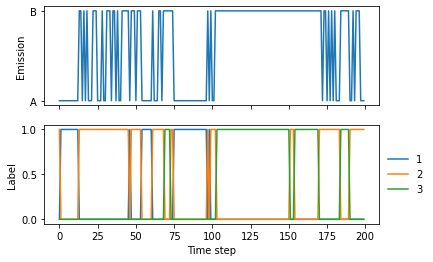

In [29]:
xs, ys = data[0]
lines = {}
for state in t_dists:
    lines[state] = [x == state for x in xs]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
axs[1].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

Now let's implement the MLEs for the transition probabilities. Before, though, we should discuss selection of the model structure, that is, the number of states and the allowed transitions between those states. Since in this case the data is simulated, we know the structure exactly. However, real-world data are often far more complicated since it's rare to have perfect knowledge of the underlying process that generated the data even if they are labeled. That said, constraining the allowed transitions can lead to better models, particularly if the constraints reflect a feature of the data generating process.

For this example, we'll assume that we have some "domain knowledge" that permits us to know the states and their allowed transitions. For example, state 2 can transition to every state, but states 1 and 3 can only transition to themselves and state 2. We'll also add a small pseudocount for the allowed transitions to ensure they're permitted by our model in the extremely rare chance that we don't observe them in the data. There are a variety of ways to implement this, but in the approach shown below we'll start by instantiating a transition count dictionary with the pseudocounts. We'll then iterate over the data to add the observed transitions. Finally, we'll normalize the counts by the total number for each initial state to obtain the estimated transition probabilities.

The benefit of this approach is it yields a nested dictionary which we can use as an input to the `HMM` class. We'll actually use the original `t_dists` to establish the model structure, but if it weren't available, we could create a similar nested object which encodes the same information. (Unfortunately, it's hard to avoid specifying at least some portions of the model manually unless it's fully-connected or its structure is highly modular.)

In [30]:
# Make transition count dicts and add pseudocounts
t_pseudo = 0.1
t_counts = {}
for state1, t_dist in t_dists.items():
    t_count = {}
    for state2 in t_dist:
        t_count[state2] = t_pseudo
    t_counts[state1] = t_count

# Add observed counts
for example in data:
    xs, ys = example
    state0 = xs[0]
    for state1 in xs[1:]:
        t_counts[state0][state1] += 1
        state0 = state1

# Normalize counts
t_dists_hat = {}
for state1, t_count in t_counts.items():
    t_sum = sum(t_count.values())
    t_dist_hat = {}
    for state2, count in t_count.items():
        t_dist_hat[state2] = count / t_sum
    t_dists_hat[state1] = t_dist_hat
t_dists_hat

{1: {1: 0.9500994694960212, 2: 0.04990053050397878},
 2: {1: 0.04675716440422323, 2: 0.9105992047168517, 3: 0.042643630878925},
 3: {2: 0.05028866605894865, 3: 0.9497113339410513}}

So far so good! The estimated transition probabilities are extremely close to their actual values.

Let's now estimate the emission probabilities. Since the emission distributions are also categorical, the code has nearly the same structure. However, let's make a small change to illustrate some of the choices inherent in model selection. Although we assumed we knew the states and allowed transitions perfectly, let's say this isn't true for the emissions. For example, even though we never observe states 1 and 3 emitting an A and B, respectively, we still aren't 100% convinced that it's impossible. Thus, we'll first gather all the possible emission types from the data and instantiate the emission distributions with a small pseudocount for each type. From there, the code is largely the same.

In [7]:
# Collect all possible emissions
e_set = set()
for example in data:
    xs, ys = example
    e_set.update(ys)

# Make emission count dicts and add pseudocounts
e_pseudo = 0.1
e_counts = {}
for state in t_dists:
    e_counts[state] = {emit: e_pseudo for emit in e_set}

# Add observed counts
for example in data:
    xs, ys = example
    for state, emit in zip(xs, ys):
        e_counts[state][emit] += 1

# Normalize counts
e_dists_hat = {}
for state, e_count in e_counts.items():
    e_sum = sum(e_count.values())
    e_dist_hat = {}
    for emit, count in e_count.items():
        e_dist_hat[emit] = count / e_sum
    e_dists_hat[state] = e_dist_hat
e_dists_hat

{1: {'B': 0.00036873156342182885, 'A': 0.9996312684365781},
 2: {'B': 0.5423549343498517, 'A': 0.4576450656501482},
 3: {'B': 0.9996111975116639, 'A': 0.0003888024883359253}}

Again the estimates are very close!

Finally let's do the start distribution. The overall idea is exactly the same, except now we're working with a single distribution rather than a dictionary of distributions. As a note, we can only estimate the start distribution from the initial state of each example. Since this severely limits the amount of data relative to the transitions, it may be tempting to use the state counts over all time points instead. Technically, this quantity will estimate the equilibrium distribution of the underlying Markov process, which is a function of the transition probabilities and independent from the start distribution. However, there may be data-specific reasons to think these quantities are equal, so this is again an example of a model selection decision.

In [31]:
# Make start count dicts and add pseudocounts
start_pseudo = 0.1
start_count = {}
for state in start_dist:
    start_count[state] = start_pseudo

# Add observed counts
for example in data:
    xs, ys = example
    start_count[xs[0]] += 1

# Normalize counts
start_sum = sum(start_count.values())
start_dist_hat = {}
for state, count in start_count.items():
    start_dist_hat[state] = count / start_sum
start_dist_hat

{1: 0.10679611650485439, 2: 0.5922330097087379, 3: 0.3009708737864078}

We're now ready to combine all these individual parameter estimates into our estimated model.

In [32]:
model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)
model_hat

HMM(states={1, 2, 3},
    stop_states=[],
    name='hmm')

Though the estimates match the parameters closely, to really see how well they compare, let's make some predictions using both. We'll use posterior decoding to obtain a distribution over states at each time step since this will give us a more nuanced picture of how each model interprets the data.

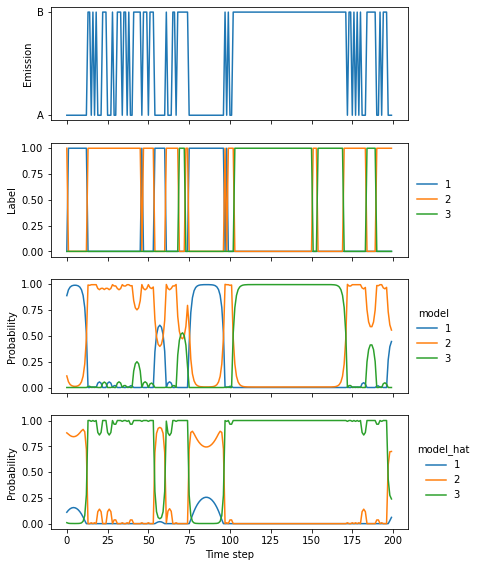

In [33]:
xs, ys = data[0]
fbs = model.forward_backward(ys)
fbs_hat = model_hat.forward_backward(ys)

fig, axs = plt.subplots(4, 1, figsize=(6.4, 9.6), sharex=True)

axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
for state, line in sorted(fbs.items()):
    axs[2].plot(line, label=state)
for state, line in sorted(fbs_hat.items()):
    axs[3].plot(line, label=state)
axs[3].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[2].set_ylabel('Probability')
axs[3].set_ylabel('Probability')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(title='model', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[3].legend(title='model_hat', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

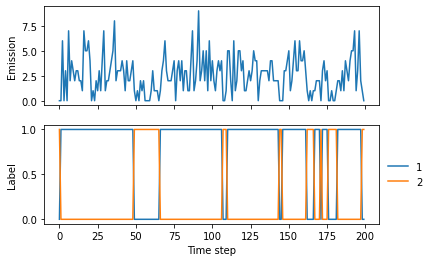

In [62]:
t_dists = {1: {1: 0.95, 2: 0.05},
           2: {1: 0.25, 2: 0.75}}
e_dists = {1: stats.poisson(3),
           2: stats.poisson(0.5)}
start_dist = {1: 0.5, 2: 0.5}

model = homomorph.HMM(t_dists=t_dists, e_dists=e_dists, start_dist=start_dist)

data = [model.simulate(200, random_state=i) for i in range (10)]  # Use a different random seed for each example
data = [list(zip(*example)) for example in data]

xs, ys = data[0]
lines = {}
for state in t_dists:
    lines[state] = [x == state for x in xs]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
axs[1].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

The posterior decoding curves are effectively identical. There are, of course, some minor differences but no real patterns that I can see. Generally these models are good at detecting the time steps corresponding to state 1 but much worse at distinguishing between states 2 and 3. We can understand this qualitatively by examining the original model parameters. State 1 is highly "sticky" and only emits As, so long runs of As are extremely likely to correspond to state 1. State 3 only emits Bs, but it's just as likely to switch to state 2 as it is to remain in state 3. Additionally, state 2 is equally likely to emit an A as a B, so it's difficult to know if a B was emitted because the model remained in state 3 or because it switched to state 2. This shows that state inference can be highly variable even if the parameters are known exactly.

#### 2.3.2 Discrete emission distribution

For the next example, we'll derive and implement the MLE for the rate of a Poisson distribution. Poisson distributions are commonly used to model count data with no upper bound. The underlying assumptions are the counts represent events that occur with some fixed average rate over time, and that the number of events in one interval is independent of the number of events in any other non-overlapping interval. These conditions impose few restrictions, so Poisson distributions are used to model a wide range of phenomena, ranging from the number of particle decays in a radioactive sample to the number of requests arriving at a web server.

If the events of a Poisson process $X$ occur at an average rate of $\lambda$, then the probability that $x$ events are observed in a given interval of length $t$ is given by

$$
\begin{aligned}
P(X = x | \lambda, t)
&= f(x, \lambda, t) \\
&= e^{-\lambda t} \frac{(\lambda t)^x}{x!}
\end{aligned}
$$

The rate $\lambda$ and length of the interval $t$ always appear as the product $\lambda t$, so Poisson distributions are often parametrized in terms of $\lambda$ only. Confusingly, this is sometimes still called a rate even though it is technically a unitless quantity. To match these conventions, I'll also drop $t$ as a parameter, although I'll avoid calling $\lambda$ a rate parameter.

We can now write the likelihood function explicitly.

$$
\begin{aligned}
L(\lambda)
&= \sum_{i=1}^N \log f(x_i, \lambda) \\
&= \sum_{i=1}^N \log \left( e^{-\lambda} \frac{\lambda^x_i}{x_i!} \right) \\
&= \sum_{i=1}^N -\lambda + x_i \log \lambda - \log (x_i!) \\
&= -N\lambda + \sum_{i=1}^N x_i \log \lambda - \log (x_i!) \\
\end{aligned}
$$

To find the MLE for $\lambda$, we 1) take the derivative relative to $\lambda$ and 2) solve for $\lambda$ when this expression is zero. In the second step, we're solving for specific values where the derivative is zero, so I'll replace $\lambda$ with $\hat{\lambda}$ to clarify this distinction.

**Step 1**
$$
\begin{aligned}
\frac{dL(\lambda)}{d\lambda}
&= -N + \sum_{i=1}^N \frac{x_i}{\lambda}
\end{aligned}
$$

**Step 2**
$$
\begin{aligned}
0 &= -N + \sum_{i=1}^N \frac{x_i}{\hat{\lambda}} \\
N &= \frac{\sum_{i=1}^N x_i}{\hat{\lambda}} \\
\hat{\lambda} &= \frac{\sum_{i=1}^N x_i}{N} = \bar{x}
\end{aligned}
$$

Pleasingly, the MLE for $\lambda$ is the sample average. Now let's implement this in code using a model with two arbitrary states. This will follow the same format as the previous section beginning with $\lambda$, so I'll proceed with little comment.

The estimator for each state's $\lambda$ is simply the average of the observations associated with that state. However, the observations are separated across multiple examples and not organized by state, so we'll first gather them in a dictionary keyed by state and then take the average.

In [63]:
# Make emission dicts keyed by state
state2emits = {}
for state in t_dists:
    state2emits[state] = []

# Add emissions
for example in data:
    xs, ys = example
    for state, emit in zip(xs, ys):
        state2emits[state].append(emit)

# Average emissions
lambda_hats = {}
for state, emits in state2emits.items():
    lambda_hat = sum(emits) / len(emits)
    lambda_hats[state] = lambda_hat
lambda_hats

{1: 2.991077119184194, 2: 0.46635730858468677}

Though the raw parameter estimates are convenient for inspection, we actually need a dictionary of SciPy random variables.

In [64]:
e_dists_hat = {state: stats.poisson(lambda_hat) for state, lambda_hat in lambda_hats.items()}

The estimators for the transition and start distributions are the same, so we can copy those cells from the previous example.

In [65]:
# Make transition count dicts and add pseudocounts
t_pseudo = 0.1
t_counts = {}
for state1, t_dist in t_dists.items():
    t_count = {}
    for state2 in t_dist:
        t_count[state2] = t_pseudo
    t_counts[state1] = t_count

# Add observed counts
for example in data:
    xs, ys = example
    state0 = xs[0]
    for state1 in xs[1:]:
        t_counts[state0][state1] += 1
        state0 = state1

# Normalize counts
t_dists_hat = {}
for state1, t_count in t_counts.items():
    t_sum = sum(t_count.values())
    t_dist_hat = {}
    for state2, count in t_count.items():
        t_dist_hat[state2] = count / t_sum
    t_dists_hat[state1] = t_dist_hat
t_dists_hat

{1: {1: 0.9487589559877175, 2: 0.0512410440122825},
 2: {1: 0.19452247191011232, 2: 0.8054775280898876}}

In [66]:
# Make start count dicts and add pseudocounts
start_pseudo = 0.1
start_count = {}
for state in start_dist:
    start_count[state] = start_pseudo

# Add observed counts
for example in data:
    xs, ys = example
    start_count[xs[0]] += 1

# Normalize counts
start_sum = sum(start_count.values())
start_dist_hat = {}
for state, count in start_count.items():
    start_dist_hat[state] = count / start_sum
start_dist_hat

{1: 0.303921568627451, 2: 0.696078431372549}

With the parameter estimates in hand, we can instantiate an estimated model and compare the decoded states to those from the actual model and the labels themselves.

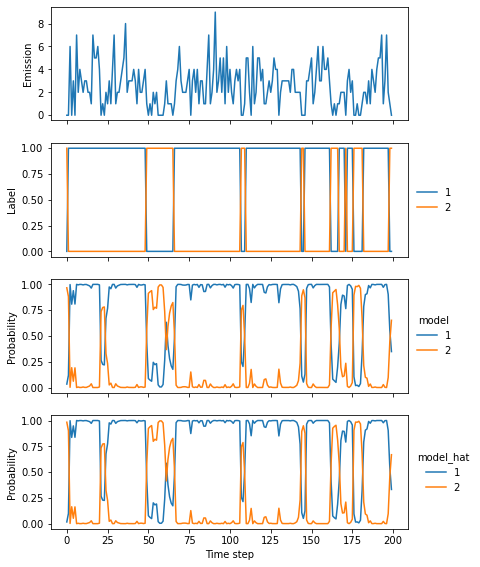

In [67]:
model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)

xs, ys = data[0]
fbs = model.forward_backward(ys)
fbs_hat = model_hat.forward_backward(ys)

fig, axs = plt.subplots(4, 1, figsize=(6.4, 9.6), sharex=True)

axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
for state, line in sorted(fbs.items()):
    axs[2].plot(line, label=state)
for state, line in sorted(fbs_hat.items()):
    axs[3].plot(line, label=state)
axs[3].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[2].set_ylabel('Probability')
axs[3].set_ylabel('Probability')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(title='model', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[3].legend(title='model_hat', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

#### 2.3.3 Continuous emission distribution

The normal distribution, with its iconic bell-shaped density curve, is practically synonymous with statistics. This association is appropriate as the normal distribution underlies many foundational results and methods in both mathematical and applied statistics. For our purposes, however, we only need to know that the normal distribution is a common and robust model for continuous measurements, so in this example we'll derive the MLEs for its parameters.

As you saw in the previous example, once the MLEs are derived, the implementations are often a straightforward translation from mathematical symbols to code. In fact, for many common distributions, including the normal distribution, the MLEs have closed-form expressions that can be interpreted in terms of standard statistical quantities like the sample mean or variance. Thus, for this example I'll skip the implementations and only present the derivation.

Let's first review the pdf of a normal distribution.

$$
f(x, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left( x-\mu \right)^2}{2\sigma^2}}
$$

Though the expression is a little intimidating, the important take-away is the distribution has two parameters $\mu$ and $\sigma^2$, which are equal to its mean and variance, respectively. In qualitative terms, $\mu$ controls the position of the peak of the curve and $\sigma^2$ controls its width.

We will now substitute this expression into the likelihood function.

$$
\begin{aligned}
L(\mu, \sigma^2)
&= \sum_{i=1}^N \log f(x_i, \lambda) \\
&= \sum_{i=1}^N -\frac{1}{2}\log(2\pi) - \frac{1}{2}\log(\sigma^2) - \frac{\left( x_i-\mu \right)^2}{2\sigma^2} \\
&= -\frac{N}{2}\log(2\pi) - \frac{N}{2}\log(\sigma^2) - \sum_{i=1}^N \frac{\left( x_i-\mu \right)^2}{2\sigma^2}
\end{aligned}
$$

As the pdf has two parameters, $\mu$ and $\sigma^2$, the likelihood is a function of these variables. This changes the next steps since we have to take the partial derivative relative to each and solve the resulting system of equations. Luckily, in this case the algebra works out nicely, but numerical optimization techniques are often required in general.

Let's start with the partial derivative for $\mu$. A subtle point for distributions with multiple parameters is in the second step when the derivative is set to zero, we replace each parameter with its estimated counterpart since we're solving for specific points where the derivatives relative to each parameter are simultaneously zero.

**Step 1**

$$
\begin{aligned}
\frac{\partial L}{\partial \mu}
&= \sum_{i=1}^N \frac{\left( x_i- \mu \right)}{\sigma^2}
\end{aligned}
$$

**Step 2**

$$
\begin{aligned}
0 &= \sum_{i=1}^N \frac{\left( x_i- \hat{\mu} \right)}{\hat{\sigma}^2} \\
N\hat{\mu} &= \sum_{i=1}^N x_i \\
\hat{\mu} &= \frac{\sum_{i=1}^N x_i}{N} = \bar{x}
\end{aligned}
$$

Now let's find the MLE for $\sigma^2$. Another subtle point for the normal distribution in particular is the derivative is taken relative to the variance, $\sigma^2$, not the standard deviation, $\sigma$. Though this choice does not impact the resulting formula, it both simplifies the process and reflects the natural role of the variance as the more "fundamental" statistical quantity.

**Step 1**

$$
\begin{aligned}
\frac{\partial L}{\partial \sigma^2}
&= -\frac{N}{2\sigma}^2 + \sum_{i=1}^N \frac{\left( x_i- \mu \right)^2}{2\sigma^4}
\end{aligned}
$$

**Step 2**
$$
\begin{aligned}
0 &= -\frac{N}{2\hat{\sigma}^2} + \sum_{i=1}^N \frac{\left( x_i- \hat{\mu} \right)^2}{2\hat{\sigma}^4} \\
\frac{N}{\hat{\sigma}^2} &= \sum_{i=1}^N \frac{\left( x_i- \hat{\mu} \right)^2}{\hat{\sigma}^4} \\
{\hat{\sigma}^2} &= \frac{\sum_{i=1}^N \left( x_i- \hat{\mu} \right)^2}{N}
\end{aligned}
$$

As I hinted in the introduction for this section, the MLEs for $\mu$ and $\sigma^2$ are simply the sample mean and standard deviation! Notice the MLE for $\sigma^2$ includes $\hat{\mu}$, so in practice we would calculate $\hat{\mu}$ first and substitute that value in the expression for $\hat{\sigma}^2$. Those with some background in statistics might notice the formula for $\hat{\sigma}^2$ has a factor of $N$ rather than $N-1$ in the denominator. This is no typo. It turns out that while MLEs are optimal in many ways, they are not always unbiased, meaning they have tendency to be a little higher or lower than the true value. In this case, the MLE for $\sigma^2$ is a little low by a factor of exactly $\frac{N-1}{N}$ on average, so some formulas divide by this quantity to remove the bias. This actually makes our estimate more imprecise, so there are some trade-offs involved in using one formula over the other. The good news is the difference is trivial for most data sets of realistic size, so the choice is largely inconsequential.

## 3 Training with unknown states

### 3.1 Estimation-maximization, informally

When we knew the states, we could assign each emission to a single likelihood functions and optimize the parameters of each function separately. However, when the states are unknown, the problem of estimating parameters is much harder, in part because the likelihood doesn't factor into independent products. (There's another more intractable issue that we'll discuss in the next section.) Not all hope is lost though. Remember that we can estimate parameters when we know the states, and when we know parameters we can estimate state probabilities. While this may seem like a chicken and egg problem, we can use this relationship as an iterative method for estimating parameters when the state labels are unknown. In practice, it works as the following:

1. Make an informed guess of the initial parameters.
2. Use the current parameters to estimate posterior state probabilities.
3. Use the posterior state probabilities to improve the parameter estimates.
4. Repeat steps 2 and 3 a set number of times or until some convergence criteria is met.

In the context of HMMs, this procedure is known as the Baum-Welch algorithm, but it's a special case of a more general technique called estimation-maximization (EM). Though it intuitively makes sense, it's not at all clear that it'll work in practice. For example, the likelihood function could ping-pong up and down without ever settling down to a single value. Fortunately, each iteration is guaranteed to improve the likelihood. Unfortunately, the sequence may converge to a local rather than a global maximum (a good answer but not necessarily the best). Thus, it's common to run the algorithm multiple times with different initial parameters and choose the final parameters with the largest likelihood.

Hopefully this discussion has given you conceptual overview of the Baum-Welch algorithm. Clearly I've skipped many details, so in the next section we'll implement it from scratch for categorical distributions. Then in the following sections, I'll introduce the EM algorithm formally and use it to derive the update equations for a normal distribution.

### 3.2 Implementing Baum-Welch for categorical distributions

All the steps in the Baum-Welch algorithm as I've presented it above should make sense except step 3. How exactly do we use posterior decoding to improve the parameter estimates? For a generic distribution, we'll need the EM formalism to derive the update equations properly, but for a categorical distribution we can intuit our way to the answer. We'll start with the transition distributions since I've already introduced their MLEs, but then we'll derive a similar result for the emission distributions. Recall that the MLEs for the parameters of a transition distribution are written in terms of the number of observed transitions between states $i$ and $j$, $n_{ij}$.

$$
\hat{a}_{ij} = \frac{n_{ij}}{\sum_{j=1}^S n_{ij}}
$$

Unfortunately, we don't have access to these counts since the states are unknown. However, what if we replaced these hard counts with how often we thought they happened under our current parameter estimates? For example, if between a time $t$ and $t+1$, we calculate there's a 75% chance the process remained in state 1 and a 25% chance it transitioned to state 2, that's effectively a 0.75 count towards $n_{11}$ and a 0.25 count towards $n_{10}$. Although we originally defined the $n_{ij}$ variables in terms of whole numbers, the equations still yield valid estimates with fractional counts.

Now the name of the game is to calculate these probabilities over all time steps. Formally we're looking for

$$
\begin{aligned}
n_{ij}
&= \sum_{t=1}^{T-1} P(X_t=i, X_{t+1}=j|Y=y, \theta) \\
&= \frac{1}{P(Y|\theta)}
   \sum_{t=1}^{T-1} P(X_t=i, X_{t+1}=j, Y=y|\theta) \\
&= \frac{1}{P(Y|\theta)}
   \sum_{t=1}^{T-1} P(X_t=i, Y_1=y_1, \ldots, Y_t=y_t|\theta)
                    P(X_{t+1}=j, Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T|X_t=i, Y_1=y_1, \ldots, Y_t=y_t, \theta) \\
&= \frac{1}{P(Y|\theta)}
   \sum_{t=1}^{T-1} P(X_t=i, Y_1=y_1, \ldots, Y_t=y_t|\theta)
                    P(X_{t+1}=j, Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T|X_t=i, \theta)
\end{aligned}
$$

The first term is the forward variable evaluated at time $t$ and state $i$, which we'll denote by $f_i(t)$. I haven't formally introduced this quantity in this tutorial, but we can easily obtain these values with the `forward` method of an `HMM` instance. Incidentally, $P(Y|\theta)=\sum_i f_i(T)$ since this sums the probability of the entire emission sequence over all possible final states. Let's now focus on the second term in the sum and define the following events to clean up the notation.

- $A: Y_{t+2}=y_{t+2}, \ldots, Y_T=y_t$
- $B: Y_{t+1}=y_{t+1}$
- $C: X_{t+1}=j$
- $D: X_t=i$

Thus, we have

$$
\begin{aligned}
P(X_{t+1}=j, Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T|X_t=i, \theta)
&= P(A, B, C|D, \theta) \\
&= P(A|B, C, D, \theta) \cdot P(B|C, D, \theta) \cdot P(C|D, \theta) \\
&= P(A|C, \theta) \cdot P(B|C, \theta) \cdot P(C|D, \theta) \\
\end{aligned}
$$

From right to left, the third term is $a_{ij}$, the second term is $e_j(y_{t+1})$, and the first term is the backward variable evaluated at time $t+1$ and state $j$, which we'll denote by $b_j(t+1)$. Analogous to the forward variable, the backward variable is available via the `backward` method of an `HMM` instance.

Putting everything together we have

$$
n_{ij} = \frac{1}{P(Y|\theta)} \sum_{t=1}^{T-1} f_i(t)a_{ij}e_j(y_{t+1})b_j(t+1)
$$

Now let's tackle the emission distributions. When the states are known, the MLEs are the same, but instead of counting transitions between states, we count emissions. (The emissions essentially take on the role of the "target" state $j$.) When the states are unknown, we replace these counts with how much we think each state is responsible for each emission. In other words, if at time $t$ we observe emission $j$ and we calculate an 90% chance of state 1 and a 10% chance of state 2, we assign a 0.9 count towards $n_{1j}$ and a 0.1 count towards $n_{2j}$. Written mathematically

$$
\begin{aligned}
n_{ij}
&= \sum_{t: y_t=j} P(X_t=i|Y=y, \theta) \\
&= \frac{1}{P(Y=y|\theta)}
   \sum_{t: y_t=j} P(X_t=i, Y=y|\theta) \\
&= \frac{1}{P(Y=y|\theta)}
   \sum_{t: y_t=j} P(Y_1=y_1, \ldots, Y_t=y_t|X_t=i, Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T, \theta)
                   P(Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T| X_t=i, \theta) \\
&= \frac{1}{P(Y=y|\theta)}
   \sum_{t: y_t=j} f_i(t)b_i(t)
\end{aligned}
$$

With these results, we can implement the Baum-Welch algorithm. I'll use the same example from the MLE section, so we can compare the performance of the two methods.

In [42]:
t_dists = {1: {1: 0.95, 2: 0.05},
           2: {1: 0.05, 2: 0.9, 3: 0.05},
           3: {2: 0.05, 3: 0.95}}
e_dists = {1: {'A': 1},
           2: {'A': 0.5, 'B': 0.5},
           3: {'B': 1}}
start_dist = {1: 0.2, 2: 0.5, 3: 0.3}

model = homomorph.HMM(t_dists=t_dists, e_dists=e_dists, start_dist=start_dist)

data = [model.simulate(200, random_state=i) for i in range (10)]  # Use a different random seed for each example
data = [list(zip(*example)) for example in data];

To start the algorithm, we first need a model architecture and then initial estimates for its parameters. To keep things comparable with the previous example, I'll assume we know the disallowed transitions but not the disallowed emissions. Though I'll use uniform random values for the initial pseudocounts to keep the code simple, you may want to use specific distributions for each. Additionally, while it's good practice to use the best result from several different random initializations, if you choose to hard code the initial parameters, you must ensure the states are different from each other in some way. If the states are all identical, there's no way for the model to "break symmetry," and all the updates will yield parameters that are the same as the initial ones.

In [52]:
random.seed(1)

# Make transition count dicts and add pseudocounts
t_counts = {}
for state1, t_dist in t_dists.items():
    t_count = {}
    for state2 in t_dist:
        t_count[state2] = random.random()
    t_counts[state1] = t_count

# Normalize counts
t_dists_hat = {}
for state1, t_count in t_counts.items():
    t_sum = sum(t_count.values())
    t_dist_hat = {}
    for state2, count in t_count.items():
        t_dist_hat[state2] = count / t_sum
    t_dists_hat[state1] = t_dist_hat
t_dists_hat

{1: {1: 0.13685528663315571, 2: 0.8631447133668443},
 2: {1: 0.5043817911017634, 2: 0.16844258615115162, 3: 0.3271756227470851},
 3: {2: 0.4082259386891194, 3: 0.5917740613108805}}

In [53]:
random.seed(2)

# Collect all possible emissions
e_set = set()
for example in data:
    xs, ys = example
    e_set.update(ys)

# Make emission count dicts and add pseudocounts
e_counts = {}
for state in t_dists:
    e_counts[state] = {emit: random.random() for emit in e_set}

# Normalize counts
e_dists_hat = {}
for state, e_count in e_counts.items():
    e_sum = sum(e_count.values())
    e_dist_hat = {}
    for emit, count in e_count.items():
        e_dist_hat[emit] = count / e_sum
    e_dists_hat[state] = e_dist_hat
e_dists_hat

{1: {'B': 0.5021552995618842, 'A': 0.49784470043811585},
 2: {'B': 0.39987288219487493, 'A': 0.6001271178051251},
 3: {'B': 0.531667470841593, 'A': 0.4683325291584069}}

In [54]:
random.seed(3)

# Make start count dicts and add pseudocounts
start_count = {}
for state in start_dist:
    start_count[state] = random.random()

# Normalize counts
start_sum = sum(start_count.values())
start_dist_hat = {}
for state, count in start_count.items():
    start_dist_hat[state] = count / start_sum
start_dist_hat

{1: 0.2065397992628295, 2: 0.47236009956297115, 3: 0.32110010117419935}

Let's now code the main loop. Mathematically we can define convergence when the improvements in the log-likelihood are below some threshold, `epsilon`. In practice, this may take too long, so we'll also define a maximum number of iterations, `max_iter`. What follows is a fairly straightforward implementation of the equations we derived previously. There are two nuanced points, however. First, to preserve the model architecture, the counts are always taken over the allowed transitions or emissions. (In theory, disallowed transitions or emissions should always have a probability of zero, but floating point errors may yield unexpected results.) Second, the forward and backward variables are scaled to sum to 1 at each time step for numerical stability. Thus, the true value at time $t$ is a product of the raw value and all the scaling factors up to and including time $t$. (Since the backward variable is calculated recursively from the final instead of the first observation, the product is taken from $t$ to to $T$.) A side effect of this representation is $P(Y|\theta)$ is simply the product of all the scaling factors.

In [55]:
epsilon = 0.01
max_iter = 100

ll0 = None
model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)
for i in range(max_iter):
    # Initialize count dictionaries
    ps = []
    t_counts = {state1: {state2: 0 for state2 in t_dist} for state1, t_dist in t_dists_hat.items()}
    e_counts = {state: {emit: 0 for emit in e_dist} for state, e_dist in e_dists_hat.items()}
    start_count = {state: 0 for state in start_dist_hat}
    
    # Get counts across all examples
    for example in data:
        xs, ys = example
        fs, ss_f = model_hat.forward(ys)
        bs, ss_b = model_hat.backward(ys)
        
        p = reduce(lambda x, y: x+y, map(log, ss_f))
        ss_f = list(accumulate(map(log, ss_f)))
        ss_b = list(accumulate(map(log, ss_b[::-1])))[::-1]
        ps.append(p)
        
        # t_counts
        for t in range(len(ys)-1):
            for state1, t_count in t_counts.items():
                for state2 in t_count:
                    count = fs[state1][t]*t_dists_hat[state1][state2]*e_dists_hat[state2][ys[t+1]]*bs[state2][t+1]
                    t_count[state2] += count * exp(ss_f[t] + ss_b[t+1] - p)
        
        # e_counts
        for t in range(len(ys)):
            for state, e_count in e_counts.items():
                if ys[t] in e_count:
                    count = fs[state][t]*bs[state][t]
                    e_count[ys[t]] += count * exp(ss_f[t] + ss_b[t] - p)
        
        # start_count
        for state in start_count:
            count = fs[state][0]*bs[state][0]
            start_count[state] += count * exp(ss_f[0] + ss_b[0] - p)
        
    # Format parameters for display
    t_string = pprint.pformat(t_dists_hat).replace('\n', '\n' + len('t_dists: ')*' ')
    e_string = pprint.pformat(e_dists_hat).replace('\n', '\n' + len('e_dists: ')*' ')
    start_string = pprint.pformat(start_dist_hat)
    
    # Check stop condition
    # Don't want to repeat calculations, so ith iterate checks previous update
    # For example, 0th iterate shows initial parameters and 1st iterate shows results of first update
    ll = sum(ps)
    if ll0 is not None and abs(ll - ll0) < epsilon:
        print(f'FINAL VALUES')
        print('log-likelihood:', ll)
        print('Δlog-likelihood:', ll-ll0 if ll0 is not None else None)
        print('t_dists:', t_string)
        print('e_dists:', e_string)
        print('start_dist:', start_string)
        break
    
    # Print results
    print(f'ITERATION {i}')
    print('log-likelihood:', ll)
    print('Δlog-likelihood:', ll-ll0 if ll0 is not None else None)
    print('t_dists:', t_string)
    print('e_dists:', e_string)
    print('start_dist:', start_string)
    print()
    
    # Normalize all counts and update model
    t_dists_hat = {}
    for state1, t_count in t_counts.items():
        t_sum = sum(t_count.values())
        t_dist_hat = {}
        for state2, count in t_count.items():
            t_dist_hat[state2] = count / t_sum
        t_dists_hat[state1] = t_dist_hat
    
    e_dists_hat = {}
    for state, e_count in e_counts.items():
        e_sum = sum(e_count.values())
        e_dist_hat = {}
        for emit, count in e_count.items():
            e_dist_hat[emit] = count / e_sum
        e_dists_hat[state] = e_dist_hat
    
    start_sum = sum(start_count.values())
    start_dist_hat = {}
    for state, count in start_count.items():
        start_dist_hat[state] = count / start_sum
    
    ll0 = ll
    model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)

ITERATION 0
log-likelihood: -1394.8845152869847
Δlog-likelihood: None
t_dists: {1: {1: 0.13685528663315571, 2: 0.8631447133668443},
          2: {1: 0.5043817911017634, 2: 0.16844258615115162, 3: 0.3271756227470851},
          3: {2: 0.4082259386891194, 3: 0.5917740613108805}}
e_dists: {1: {'A': 0.49784470043811585, 'B': 0.5021552995618842},
          2: {'A': 0.6001271178051251, 'B': 0.39987288219487493},
          3: {'A': 0.4683325291584069, 'B': 0.531667470841593}}
start_dist: {1: 0.2065397992628295, 2: 0.47236009956297115, 3: 0.32110010117419935}

ITERATION 1
log-likelihood: -1370.0483935213563
Δlog-likelihood: 24.836121765628377
t_dists: {1: {1: 0.1369014030116976, 2: 0.8630985969883024},
          2: {1: 0.5005076052579212, 2: 0.16781270928578224, 3: 0.33167968545629645},
          3: {2: 0.39099227077840504, 3: 0.609007729221595}}
e_dists: {1: {'A': 0.5182334034811681, 'B': 0.4817665965188319},
          2: {'A': 0.5425713431986029, 'B': 0.457428656801397},
          3: {'A': 0

ITERATION 15
log-likelihood: -920.8774559220449
Δlog-likelihood: 0.3705931732665704
t_dists: {1: {1: 0.21012447349877078, 2: 0.7898755265012293},
          2: {1: 0.6924215946919577, 2: 0.19239010471704798, 3: 0.1151883005909942},
          3: {2: 0.06293920466675293, 3: 0.9370607953332472}}
e_dists: {1: {'A': 0.8873780013739165, 'B': 0.11262199862608338},
          2: {'A': 0.8960115546011792, 'B': 0.10398844539882093},
          3: {'A': 0.08332911467452817, 'B': 0.9166708853254718}}
start_dist: {1: 0.38909757572908427, 2: 0.07011138625921148, 3: 0.5407910380117043}

ITERATION 16
log-likelihood: -920.5461500931767
Δlog-likelihood: 0.3313058288681532
t_dists: {1: {1: 0.20999066573154304, 2: 0.790009334268457},
          2: {1: 0.6919436786481133, 2: 0.19307373564714775, 3: 0.11498258570473903},
          3: {2: 0.06199318765293351, 3: 0.9380068123470664}}
e_dists: {1: {'A': 0.8870781154036433, 'B': 0.11292188459635663},
          2: {'A': 0.9015324740920192, 'B': 0.09846752590798072},

ITERATION 30
log-likelihood: -916.3181925975653
Δlog-likelihood: 0.3492987672123036
t_dists: {1: {1: 0.19692580021638298, 2: 0.803074199783617},
          2: {1: 0.6752348886243897, 2: 0.19360970921295642, 3: 0.13115540216265373},
          3: {2: 0.05827800337096054, 3: 0.9417219966290393}}
e_dists: {1: {'A': 0.9287397571388577, 'B': 0.07126024286114227},
          2: {'A': 0.9606925602405575, 'B': 0.03930743975944256},
          3: {'A': 0.12322357372377893, 'B': 0.876776426276221}}
start_dist: {1: 0.40094644050491085, 2: 0.0005955456986669043, 3: 0.5984580137964223}

ITERATION 31
log-likelihood: -915.9658227090237
Δlog-likelihood: 0.35236988854160245
t_dists: {1: {1: 0.1956268811648702, 2: 0.8043731188351297},
          2: {1: 0.6739546412190227, 2: 0.193382130070764, 3: 0.13266322871021327},
          3: {2: 0.058137494379068386, 3: 0.9418625056209315}}
e_dists: {1: {'A': 0.9332376815611583, 'B': 0.06676231843884181},
          2: {'A': 0.9640275861592432, 'B': 0.03597241384075678}

ITERATION 46
log-likelihood: -911.985822727012
Δlog-likelihood: 0.1008580376600321
t_dists: {1: {1: 0.17758268724362178, 2: 0.8224173127563783},
          2: {1: 0.6683558170533422, 2: 0.19004177427355134, 3: 0.14160240867310642},
          3: {2: 0.05300743517409057, 3: 0.9469925648259093}}
e_dists: {1: {'A': 0.9814201966289983, 'B': 0.018579803371001652},
          2: {'A': 0.9946332455150079, 'B': 0.005366754484992112},
          3: {'A': 0.15843459508085386, 'B': 0.8415654049191461}}
start_dist: {1: 0.3454848859416194, 2: 1.7826259284827458e-06, 3: 0.6545133314324522}

ITERATION 47
log-likelihood: -911.9054180134501
Δlog-likelihood: 0.08040471356184753
t_dists: {1: {1: 0.1765172560958696, 2: 0.8234827439041303},
          2: {1: 0.6688279305069017, 2: 0.18973762912162817, 3: 0.14143444037147007},
          3: {2: 0.05268780828793471, 3: 0.9473121917120653}}
e_dists: {1: {'A': 0.9825790120157951, 'B': 0.01742098798420491},
          2: {'A': 0.9953391847267383, 'B': 0.00466081527326

Based on the results, the algorithm seems to have merged states 1 and 2 into a single state that only emits A. State 3 is still biased toward B, but it's much more likely to emit an A in order to "capture" the emissions that can no longer be attributed to state 2. There are two possible reasons why this happened. First, the initial values are bad. We chose them randomly, so maybe we were unlucky, and there was a "bad" local maximum near those initial values. As a side note, it's actually surprising that the algorithm didn't exchange the states associated with the A and B emissions given that we didn't prime the initial values with any information that state 1 only emits A and state 3 only emits B. For both these reasons, it's best practice to use multiple initializations that are random but still encode the expected behavior for each state. Try playing around with different random seeds or initialization schemes to see if the fit improves!

The second reason why the algorithm merged states 1 and 2 is state 2 is inherently difficult to fit. Under the current parameters, state 2 is just as likely to emit an A as a B, which maximizes the uncertainty associated with its emissions. (Compare this to states 1 or 3 whose emissions we know with certainty.) While this example is highly artificial, it illustrates that although we can define an HMM however we like, its emission distribution may be well-described by multiple sets of parameters, *i.e.*, the likelihood surface is broad and flat or has multiple peaks.

### 3.3 Estimation-maximization, formally

Though what we've done so far makes sense intuitively, let's look at what happening more formally, so we can generalize this approach to other emission distributions. Recall that in maximum likelihood estimation, we find parameters that maximize the logarithm of probability of the data $D$ given the parameters $\theta$

$$
\begin{aligned}
\hat{\theta}
&= \text{argmax}_\theta L(\theta) \\
&= \text{argmax}_\theta \log P(D|\theta)
\end{aligned}
$$

In the HMM setting with known states, the data is composed of $N$ examples of ordered pairs $\{(x_i, y_i)|1 \le i \le N\}$ where $x_i$ is a sequence of states and $y_i$ is a sequence of emissions, each with length $T_i$. For simplicity, however, we'll only consider a single example $(x, y)$ where $x_t$ and $y_t$ indicate the $t$th state and emission in those sequences, respectively. We can then write the likelihood function as $L(\theta) = \log P(X=x, Y=y|\theta)$. So far this is all review from the previous section. What about the case when we only know the emissions, $y$? Then the likelihood is $L(\theta) = \log P(Y=y|\theta)$. Though we can calculate this quantity directly with the forward algorithm and thus in principle apply a number of optimization algorithms, we'll instead take a probabilistic approach and write the likelihood function as a sum over all possible state sequences

$$
\begin{aligned}
L(\theta)
&= \log P(Y=y|\theta) \\
&= \log \sum_x P(Y=y, X=x|\theta)
\end{aligned}
$$

The only problem is that for an emission sequence of length $T$ and a model with $S$ hidden states, there are $T^S$ possible state sequences. This sum has an exponential number of terms and is therefore intractible to calculate for any data of realistic size.

So far this expression hasn't gotten us anywhere. However, it is possible to derive a related but more tractible quantity whose improvements lower bound improvements for this quantity. This quantity, commonly denoted as $Q(\theta|\theta_n)$, is defined as the expectation of the likelihood function with respect to the conditional distribution of the states $X$ given the emissions $y$.

$$
\begin{aligned}
Q(\theta|\theta_n)
&= E_{X|Y=y,\theta_n} \log P(Y=y, X|\theta) \\
&= \sum_x P(X=x|Y=y, \theta_n) \log P(Y=y, X=x|\theta) \\
\end{aligned}
$$

This is a confusing expression, especially since the notation for conditional expectation is dense. However, in the second line I've explicitly written the expectation as a sum, which will hopefully clarify what's happening. We have a sum of the joint likelihoods of the states and emissions given the parameters (the $\log P(Y=y, X=x|\theta$ term) where each term in the sum is weighted by the quantity $P(X=x|Y=y, \theta_n)$. Notice that $P(X=x|Y=y, \theta_n)$ is constant for a given $\theta_n$, so $Q(\theta|\theta_n)$ is function only of the likelihood terms.

Next we define the new estimates of the parameters as

$$
\theta_{n+1} = \text{argmax}_\theta Q(\theta|\theta_n)
$$

These two steps are where the name expectation-maximization is derived since the first is the calculation of an expectation, and the second is a maximization of that expectation. It may seem like we haven't done much to simplify the problem since we're still dealing with sums over all state sequences. However, by moving the sum outside the logarithm, we've greatly simplified the maximization step as we will see in the next section.

By repeating this process, we can iteratively improve our estimates of the parameters. I told you that these improvements in $Q(\theta|\theta_n)$ lower bound improvements in the likelihood. I won't show the derivation here, but what I mean by this is

$$
\log P(Y|\theta) - \log P(Y|\theta_n) \ge Q(\theta|\theta_n) - Q(\theta_n|\theta_n)
$$

Since in each step we maximize $Q(\theta|\theta_n)$, the right quantity is always non-negative. Thus, the likelihood of the emissions is improved by at least that much as well. Written mathemtically

$$
Q(\theta_{n+1}|\theta_n) - Q(\theta_n|\theta_n) \ge 0
\implies
\log P(Y|\theta_{n+1}) - \log P(Y|\theta_n) \ge 0
$$

### 3.4 Deriving the update equations for a normal distribution

We'll now apply this theory to the HMM context. First I'll show not only that $Q(\theta|\theta_n)$ is tractible to calculate but also that it decomposes into independent terms. Then I'll show how to derive the update equations for normal emission distributions. Let's get started!

Let's expand the expression for $Q(\theta|\theta_n)$ using the probabilistic structure of an HMM.
$$
\begin{aligned}
Q(\theta|\theta_n)
= &\sum_x P(X=x|Y=y, \theta_n) \log P(Y=y, X=x|\theta) \\
= &\sum_x P(X=x|Y=y, \theta_n)
          \log \left[P(Y_1=y_1|X_1=x_1, \theta)P(X_1=x_1|\theta)
                      \prod_{t=1}^{T-1} P(Y_{t+1}=y_{t+1}|X_{t+1}=x_{t+1}, \theta)P(X_{t+1}=x_{t+1}|X_t=x_t, \theta)
               \right] \\
= &\sum_x P(X=x|Y=y, \theta_n)
          \left[\log P(X_1=x_1|\theta) +
                \sum_{t=1}^T \log P(Y_t=y_t|X_t=x_t, \theta) +
                \sum_{t=1}^{T-1} \log P(X_{t+1}=x_{t+1}|X_t=x_t, \theta)
          \right] \\
= &\sum_i P(X_1=i|Y=y, \theta_n) \log P(X_1=i|\theta) \\
  &+ \sum_i \sum_{t=1}^T P(X_t=i|y, \theta_n) \log P(Y_t=y_t|X_t=i, \theta) \\
  &+ \sum_{i, j} \sum_{t=1}^{T-1} P(X_t=i, X_{t+1}=j|Y=y, \theta_n) \log P(X_{t+1}=j|X_t=i, \theta) \\
\end{aligned}
$$

In the final step, the outer sum was distributed over each term and exchanged with the inner sum. I'll show this step explicitly below for the second term. The remaining terms are simplified similarly.

$$
\begin{aligned}
\sum_x P(X=x|Y=y, \theta_n) \sum_{t=1}^T \log P(Y_t=y_t|X_t=x_t, \theta)
&= \sum_x \sum_{t=1}^T P(X=x|Y=y, \theta_n) \log P(Y_t=y_t|X_t=x_t, \theta) \\
&= \sum_i \sum_{x \setminus x_t} \sum_{t=1}^T P(X=x|y, \theta_n) \log P(Y_t=y_t|X_t=i, \theta) \\
&= \sum_i \sum_{t=1}^T \log P(Y_t=y_t|X_t=i, \theta) \sum_{x \setminus x_t} P(X=x|Y=y, \theta_n) \\
&= \sum_i \sum_{t=1}^T P(X_t=i|Y=y, \theta_n) \log P(Y_t=y_t|X_t=i, \theta) \\
\end{aligned}
$$

(In the final line, we used that the probability of a path with a fixed state $X_t=i$ is the sum of the probabilities of all paths that include that fixed state.)

Though moving the sum over all state sequences outside the logarithm seemed like a minor mathematical detail, it, in combination with the probabilistic structure of an HMM, makes its computation tractible. Another consequence is that if the transitions and emissions are all governed by different parameters, we can maximize the entire expression by optimizing the corresponding term for each state or pair of states individually. You can even see that the fractional "counts" $P(X_t=i|Y=y, \theta)$ and $P(X_t=i, X_{t+1}=j|Y=y)$ that we defined in the previous section have naturally appeared as the coefficients of the logarithms, which is directly related to their appearance in the update equations.

Now that I've demonstrated that each term can be optimized separately, I'll show the derivation of the update equations for a normal emission distribution. Recall that the density function of a normal distribution with mean $\mu$ and variance $\sigma^2$ is given by

$$
f(x, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left( x-\mu \right)^2}{2\sigma^2}}
$$

Thus, for a fixed state $i$ we want to maximize the following quantity which we'll call $q(\theta)$

$$
q(\theta) = \sum_{t=1}^T P(X_t=i|Y=y, \theta_n) \log P(Y_t=y_t|X_t=i, \theta)
$$

I'll write $w_{it} = P(X_t=i|Y=y, \theta_n)$ to simplify the notation and to emphasize this quantity is fixed during the maximization step. Now let's insert the expression for the normal density with mean $\mu_i$ and variance $\sigma_i^2$

$$
\begin{aligned}
q(\mu_i, \sigma_i^2)
&= \sum_{t=1}^T P(X_t=i|Y=y, \theta_n) \log P(Y_t=y_t|X_t=i, \theta) \\
&= \sum_{t=1}^T w_{it} \log \left(
                                  \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left( x-\mu \right)^2}{2\sigma^2}}
                             \right) \\
&= \sum_{t=1}^T w_{it} \left(
                             -\frac{1}{2}\log \sigma^2
                             -\frac{1}{2}\log 2\pi
                             -\frac{\left( y_t - \mu_i \right)^2}{2\sigma^2}
                       \right)
\end{aligned}
$$

If you've read the section on deriving the MLEs for a normal distribution, this quantity should look extremely familiar! However, let's bring it home and take some derivatives. We'll start with the parameter for the mean.

**Step 1**
$$
\frac{\partial q}{\partial \mu_i} = \sum_t^T w_{it} \frac{(y_t-\mu_i)}{\sigma_i^2}
$$

**Step 2**
$$
\begin{aligned}
0 &= \sum_{t=1}^T w_{it} \frac{(y_t-\hat{\mu}_i)}{\hat{\sigma}_i^2} \\
0 &= \sum_{t=1}^T w_{it} (y_t-\hat{\mu}_i) \\
\sum_{t=1}^T w_{it} \hat{\mu}_i &= \sum_{t=1}^T w_{it} y_t \\
\hat{\mu}_i &= \frac{\sum_{t=1}^T w_{it} y_t}{\sum_{t=1}^T w_{it}}
\end{aligned}
$$

The resulting formula is very close to the corresponding MLE we derived in the previous section. However, in this version each observation is multiplied by a weight, and we instead divide by the sum of the weights. (By setting the weight for each observation to one, we can even obtain the original formula!) Since the weights for each observation must sum to one, we're essentially partitioning each observation across all states where the amount that an observation contributes to a state is given by our confidence that it was generated by that state.

Let's now derive the update equation for the variance.

**Step 1**
$$
\frac{\partial q}{\partial \sigma_i^2} = \sum_{t=1}^T w_{it}
                                         \left( -\frac{1}{2 \sigma_i^2}
                                                + \frac{\left( y_t - \mu_i \right)^2}{2 \sigma_i^4}
                                         \right)
$$

**Step 2**

$$
\begin{aligned}
0 &= \sum_{t=1}^T w_{it}
     \left( -\frac{1}{2 \hat{\sigma}_i^2}
            + \frac{\left( y_t - \hat{\mu}_i \right)^2}{2 \hat{\sigma}_i^4}
     \right) \\
\frac{1}{\hat{\sigma}_i^2} \sum_{t=1}^T w_{it} &= \frac{1}{\hat{\sigma}_i^4}
                                                  \sum_{t=1}^T w_{it} \left( y_t - \hat{\mu}_i \right)^2 \\
\hat{\sigma}_i^2 &= \frac{\sum_{t=1}^T w_{it} \left( y_t - \hat{\mu}_i \right)^2}
                         {\sum_{t=1}^T w_{it}}
\end{aligned}
$$

Again, the update equation has the same form as the corresponding MLE except the squared deviation from the mean for each observation is weighted. This is a common occurrence when using the EM algorithm and is a consequence of the construction of the objective function as a weighted sum of likelihood functions. Thus, when the MLEs are interpretible as quantities like counts or averages, the corresponding update equations are often "weighted" versions of those estimators. Of course, it's not always obvious how the weights will come into play, especially for MLEs which don't have an obvious "interpretation," so it's good idea to solve the equations yourself or look up a reference rather than guessing.

## 4 Discriminative training

Discriminative training is technically under the heading of training with known states since it requires labeled data. However, there are enough differences in the objective function and the optimization algorithm that it deserves its own section.

### 4.1 Discriminative training theory

Adapt presentation of theory from reference paper

### 4.2 Example

Some complex, real-world data with discriminative training